# LangGraph ChatBot 开发指南

LangGraph 是一个灵活的 Agent 开发框架，可以帮助您设计复杂的对话工作流和智能代理。

本指南将指导您如何使用 LangGraph 构建一个支持**多轮对话的智能客服（聊天机器人）**。

我们将从一个基础的聊天机器人开始，逐步添加更多高级功能，并介绍关键的 LangGraph 概念。

通过以下几个部分的学习，您将掌握如何逐步构建、增强和管理该聊天机器人。

1. **构建Chatbot**： 基于 GPT-4o-mini 构建基础聊天机器人
2. **联网查询工具**：为聊天机器人添加工具（结合网络搜索回答问题）
3. **增加记忆系统**：在多次调用中保持对话状态
4. **人工介入对话**：将复杂查询路由给人工审查或手动更新内容
5. **查询历史对话**：通过状态图状态和配置查看/打印历史对话
----------



## LangGraph 核心对象介绍

#### **StateGraph 对象**

`StateGraph` 是 LangGraph 中的核心概念之一，它定义了聊天机器人或其他任务处理流程的结构。它是一种状态机，通过节点（nodes）和边（edges）来表示系统的状态变化。以下是 `StateGraph` 的关键点：

- **定义流程图**：`StateGraph` 是用来创建流程图的对象，图中的每个节点代表一个任务或计算步骤（如调用 LLM、工具或函数），每个边（edge）定义了从一个节点到下一个节点的流向。
  
- **状态管理**：`StateGraph` 通过状态（`State`）来管理流程中的数据和上下文。每个节点都会接收当前的状态，并且返回一个更新后的状态。这种机制保证了在多轮对话或任务中，机器人能够持续维护上下文信息。

- **消息更新**：在 `StateGraph` 中，我们可以定义如何更新状态，例如使用 `add_messages` 函数，表示将消息追加到已有的消息列表，而不是覆盖旧消息。

#### StateGraph 的使用步骤
1. **定义 State**：首先需要定义状态（`State`），例如用字典来存储消息、工具调用的结果等内容。
2. **添加节点**：每个节点表示一个任务单元，可以是任意的 Python 函数。
3. **添加边**：通过 `add_edge()` 方法指定节点之间的流向，例如从聊天节点到工具节点，再到结束节点。
4. **编译图**：通过 `compile()` 方法将流程图编译为可执行的 `CompiledGraph`。

-----------

#### **CompiledGraph 对象**

`CompiledGraph` 是由 `StateGraph` 编译得到的实际可执行对象。它负责执行在 `StateGraph` 中定义的流程，并处理每个节点的任务。`CompiledGraph` 通过状态的流动来管理整个对话或任务的执行。以下是 `CompiledGraph` 的关键点：

- **流程执行**：`CompiledGraph` 是 `StateGraph` 的实际运行版本。当你调用 `stream()` 或 `invoke()` 方法时，它会依次执行图中的节点，并根据每个节点的输出状态决定下一个节点的执行。

- **状态检查点（Checkpointing）**：通过使用检查点机制，`CompiledGraph` 可以在每个节点执行完后保存当前的状态，允许任务暂停并在之后恢复。例如，您可以为机器人添加记忆功能或支持“时间旅行”（回到之前的某个状态点）。

- **动态路由**：`CompiledGraph` 还支持动态路由（Conditional Edges），允许根据当前状态动态决定下一步执行的节点。这使得机器人可以根据上下文或工具的输出灵活地调整行为。

------------

#### 关系总结

- `StateGraph` 用于定义和构建一个聊天机器人或任务处理流程的结构，通过节点和边来管理流程和状态的流动。
- `CompiledGraph` 是 `StateGraph` 编译后的版本，负责实际的流程执行、状态管理和检查点保存。

它们结合在一起，提供了一个灵活、可扩展的方式来构建复杂的多步骤对话机器人或任务执行系统。

------------

## LangGraph 核心方法介绍

`graph.stream` 是 LangGraph 中的一个核心方法，用于执行编译后的状态图（`CompiledGraph`）并以流式（streaming）的方式处理每个节点。通过 `stream` 方法，系统可以逐步执行对话或任务的每个步骤，并在每一步中返回中间结果。这种方式特别适用于长时间任务、逐步处理的工具调用或连续的对话。

### `graph.stream` 的核心功能

1. **流式执行**：
   - `graph.stream` 允许您在每个节点执行时获得结果，类似于生成器的工作方式。在对话或任务流程中，机器人每经过一个节点（如调用工具、获取外部数据、与用户对话），都会返回该节点的执行结果。这使得系统可以逐步处理复杂的任务或多轮对话，而不是一次性等待所有步骤完成。

2. **中间状态反馈**：
   - 使用 `stream` 方法时，开发者可以在每一步获得当前的中间状态（如对话消息、工具调用的结果）。这对于调试、错误处理和用户实时反馈非常有帮助。
   - 比如，在对话中，系统可以在用户输入每一条消息后逐步处理，逐步生成回答，而不是一次性返回最终结果。

3. **支持多轮对话**：
   - 通过 `stream`，可以让机器人保持对话的状态，使其能够处理复杂的多轮对话。系统在每一步都会保存对话的上下文，并在接收到新消息时恢复对话的状态，继续处理。

4. **支持工具调用和多节点执行**：
   - `stream` 方法不仅支持对话，还可以用于工具调用等任务。在每个工具节点执行时，系统会返回工具的执行结果，允许您对每个步骤的输出进行检查或处理。
   - 它特别适合那些需要多个步骤或节点共同执行的任务，保证每个节点依次运行。

---

### 典型用法（涵盖1-3部分的重要功能）

#### 1. 执行对话

```python
config = {"configurable": {"thread_id": "1"}}
user_input = "Hi, can you tell me today's weather?"

# 使用 stream 方法来执行对话
events = graph.stream(
    {"messages": [("user", user_input)]},  # 传入用户的输入消息
    config,  # 对话线程配置，用于标识对话的唯一 ID
    stream_mode="values"  # 以流式返回数据
)

# 遍历每个事件，并输出机器人生成的消息
for event in events:
    print(event["messages"][-1].content)  # 打印最后一条消息的内容
```

在这个示例中，`graph.stream` 逐步处理用户的输入，并返回每个步骤的结果。由于使用了 `stream_mode="values"`，系统以流式返回对话的中间结果。

#### 2. 执行工具调用

```python
user_input = "Please search for the latest news about AI."
config = {"configurable": {"thread_id": "2"}}

# 使用 stream 方法来执行带有工具调用的任务
events = graph.stream(
    {"messages": [("user", user_input)]},  # 用户输入的消息
    config,
    stream_mode="values"
)

# 遍历事件，获取工具的调用结果
for event in events:
    if "messages" in event:
        # 打印工具的调用结果或机器人回复
        print(event["messages"][-1].content)
```

这个示例展示了如何通过 `graph.stream` 执行包含工具调用的任务。每个工具的调用结果都会在事件中返回，并且可以即时处理和反馈。

---

### `graph.stream` 的参数

- **`inputs`**：输入的字典数据，通常包含对话的消息（如 `{"messages": [("user", user_input)]}`），表示用户输入了什么信息。`inputs` 是机器人任务的初始数据。
- **`config`**：配置参数，用于指定对话线程 ID、流执行模式等选项。它允许为每个对话或任务指定唯一的标识符，以便系统可以跟踪对话的上下文或任务状态。
- **`stream_mode`**：指定返回数据的模式。常见的取值是 `"values"`，表示返回处理结果的流式数据。其他模式也可以根据具体需求进行调整。

---

### 适用场景

1. **多轮对话机器人**：在复杂的对话场景中，用户可能与机器人进行多轮对话，并且希望机器人能够持续记住对话上下文。`graph.stream` 允许在每一轮对话中返回中间结果，并保持对话的流畅性和连贯性。
  
2. **逐步执行复杂任务**：例如，机器人在执行需要多个步骤的任务时，可以通过 `stream` 方法在每个步骤执行完后返回结果，而不是一次性执行整个任务。这种逐步处理的机制可以确保任务的每一步都被正确执行，并且可以随时处理异常情况。

3. **实时反馈**：在实时应用中，用户希望能够尽快获得机器人的反馈。通过 `graph.stream`，系统可以在每个步骤中即时返回处理结果，让用户感受到流畅的交互体验。

---

### 总结

`graph.stream` 是一个强大的工具，用于以流式处理对话和任务的每个步骤。它特别适合那些需要逐步执行和处理的任务场景，如多轮对话、复杂的工具调用或任务处理。通过 `stream`，系统可以在每一步中即时返回结果，并保持任务或对话的上下文信息。

-----

## 第 1 部分：构建基础聊天机器人

我们将首先使用 LangGraph 创建一个简单的聊天机器人。该机器人将直接响应用户消息。虽然简单，但它将展示 LangGraph 构建的核心概念。在本部分结束时，您将构建一个基础的聊天机器人。

### 1. 安装依赖包

首先，安装所需的软件包：

In [1]:
%%capture --no-stderr
# 安装 LangGraph 和 LangSmith，用于状态图和跟踪
# 采用poetry来统一管理，避免环境污染 %pip install -U langgraph langsmith

### 2. 设置 LangSmith API 密钥

In [2]:
# 从配置文件中加载环境变量
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

os.environ["LANGCHAIN_TRACING_V2"]

'true'

In [3]:
import os

# 开启 LangSmith 跟踪，便于调试和查看详细执行信息
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "gk-chatbot"

### 3. 定义聊天机器人的状态图 `StateGraph`

我们将添加节点以表示聊天机器人的逻辑和功能，并添加边来指定如何在功能之间进行转换。

#### 代码解析

当定义一个状态图时，首先要定义图的状态 `State`。`State` 包含图的状态结构以及 reducer 函数，它们指定如何应用状态更新。

在本例中，`State` 是一个带有单一键 `messages` 的 `TypedDict`，该键使用 `add_messages` 函数作为注解，告诉 LangGraph 应该将新消息追加到现有消息列表中，而不是覆盖它。

没有注解的状态键将被覆盖，存储最新的值。

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# 定义状态类型，继承自 TypedDict，并使用 add_messages 函数将消息追加到现有列表
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 创建一个状态图对象，传入状态定义
graph_builder = StateGraph(State)

现在，状态图知道了两件事：

1. 每个我们定义的节点都会接收当前的 `State` 作为输入，并返回一个更新该状态的值。
2. `messages` 将追加到当前列表中，而不是直接覆盖。这通过 `Annotated` 语法中的预构建 `add_messages` 函数传达。

### 4. 添加聊天节点

节点表示一个计算单元。它们通常是常规的 Python 函数。

**代码解析：**

聊天机器人节点函数（`chatbot`）接收当前的 `State` 作为输入，并返回一个包含更新后的 `messages` 列表的字典。这是所有 LangGraph 节点函数的基础模式。

在 `State` 中的 `add_messages` 函数会将 LLM 的响应消息追加到现有的消息列表中。

In [5]:
from langchain_openai import ChatOpenAI

# 初始化一个 GPT-4o-mini 模型
chat_model = ChatOpenAI(model="gpt-4o-mini")

# 定义聊天机器人的节点函数，接收当前状态并返回更新的消息列表
def chatbot(state: State):
    return {
        "messages": [chat_model.invoke(state["messages"])]
    }

# 第一个参数是唯一的节点名称，第二个参数是每次节点被调用时的函数或对象
graph_builder.add_node("chatbot", chatbot)

### 5. 定义聊天机器人对话流程（状态图的起终点）

- **起点（START）**：每次运行时，从哪里开始工作。
- **终点（END）**：每次运行此节点时，程序可以退出。

In [6]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

### 6. 编译图并可视化

最后，我们需要能够运行我们的状态图。

在图构建器上调用 `compile()`，这会创建一个可执行的 `CompiledGraph`对象。

我们可以使用该图(`CompiledGraph`)来调用聊天机器人。

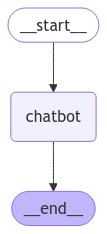

In [7]:
# 编译状态图并生成可执行图对象
graph = graph_builder.compile()

# 你可以使用 get_graph 方法来可视化图，并结合 draw 方法（如 draw_ascii 或 draw_png）
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

### 7. 运行图

**恭喜！您已经使用 LangGraph 构建了第一个聊天机器人。这个机器人可以通过接受用户输入并生成 LLM 回复来进行基本对话。**

现在运行聊天机器人！

#### 代码解析

1. **聊天循环**：
   - `while True:` 启动一个持续的聊天循环，用户可以不断输入问题或命令与聊天机器人互动。

2. **获取用户输入**：
   - 使用 `input("User: ")` 来获取用户的输入消息，并将其赋值给 `user_input` 变量。

3. **退出条件**：
   - 如果用户输入 `"quit"`、`"exit"` 或 `"q"`，系统会通过 `break` 语句退出聊天循环，结束程序运行。

4. **将用户消息传递给聊天机器人**：
   - 通过调用 `graph.stream({"messages": ("user", user_input)})`，将用户的输入传递给聊天机器人模型。`graph.stream` 方法会根据输入的消息生成相应的回复。
   - 这里 `"messages": ("user", user_input)` 表示传递的是用户的输入消息。

5. **处理机器人的回复**：
   - 遍历 `event.values()` 中的每个值，从机器人生成的回复中提取最后一条消息，并使用 `print("Assistant:", value["messages"][-1].content)` 打印输出聊天机器人的回复内容。

该代码是一个简单的聊天机器人框架，用户可以在命令行中输入问题，机器人会根据用户的输入实时生成回复。如果用户输入退出指令，程序会结束对话循环。

In [10]:
# 开始一个简单的聊天循环
while True:
    # 获取用户输入
    user_input = input("User: ")
    
    # 可以随时通过输入 "quit"、"exit" 或 "q" 退出聊天循环
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # 打印告别信息
        break  # 结束循环，退出聊天

    # 将每次用户输入的内容传递给 graph.stream，用于聊天机器人状态处理
    # "messages": ("user", user_input) 表示传递的消息是用户输入的内容
    for event in graph.stream({"messages": ("user", user_input)}):
        
        # 遍历每个事件的值
        for value in event.values():
            # 打印输出 chatbot 生成的最新消息
            print("Assistant:", value["messages"][-1].content)

Assistant: 截至我知识的截止日期（2023年10月），关于智能体框架 CrewAI 及其最新推出的 Flow 功能的信息并不在我的数据库中。因此，我无法提供关于该功能的具体细节或介绍。

不过，通常来说，智能体框架（如 CrewAI）可能会推出一些新功能以增强其智能体的能力和用户体验。Flow 功能可能涉及以下几个方面：

1. **工作流自动化**：Flow 功能可能允许用户创建和管理工作流，以自动化任务和流程，提高效率。

2. **用户交互**：可能增强智能体与用户之间的交互，提供更自然和流畅的对话体验。

3. **数据流动**：可能涉及数据在系统之间的流动，使得信息能够更快速和准确地传递。

4. **集成与兼容性**：Flow 功能可能与其他工具和平台集成，提供更广泛的应用场景。

5. **可视化界面**：用户可能能够通过可视化界面更直观地设计和管理工作流。

为了获取最新和最准确的信息，建议访问 CrewAI 的官方网站或查看相关的发布公告和文档。如果有具体问题或想了解某一方面，欢迎随时告诉我！
Goodbye!


--------------
#### 运行结果分析

问：请详细介绍下智能体框架 crewAI最新推出的Flow功能？

回答如上结果所示。GPT4OM如实回答说不清楚具体的功能，但它作了些猜想。



## 第 2 部分：为聊天机器人添加工具

为了处理我们聊天机器人无法“记住”回答的问题，我们将集成一个 Web 搜索工具 [Tavily Search](
https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/)。

我们的机器人可以使用这个工具找到相关信息，并提供更好的回复。

### 1. 安装依赖并设置 Tavily API

访问 [Tavily](https://tavily.com/) 官网，注册账号并生成你的 `TAVILY_API_KEY`。

Tavily 提供 1000次/月的免费检索额度。

在开始之前，确保您已安装 Tavily 搜索引擎所需的包并在环境变量中设置了 `TAVILY_API_KEY`。

In [8]:
%%capture --no-stderr
# 安装 Tavily 搜索引擎的 Python 包
# %pip install -U tavily-python
# %pip install -U langchain_community

In [9]:
# import getpass
# import os

# if not os.environ.get("TAVILY_API_KEY"):
#     os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

### 2. 定义工具

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults

# 定义 Tavily 搜索工具，最大搜索结果数设置为 2
tool = TavilySearchResults(max_results=2)
tools = [tool]

# 测试工具调用
tool.invoke("What's the opensource software openhands?")

[{'url': 'https://github.com/All-Hands-AI/OpenHands/',
  'content': 'For a list of open source projects and licenses used in OpenHands, please see our CREDITS.md file. 📚 Cite. @misc{openhands, title={{OpenHands: An Open Platform for AI Software Developers as Generalist Agents}}, author={Xingyao Wang and Boxuan Li and Yufan Song and Frank F. Xu and Xiangru Tang and Mingchen Zhuge and Jiayi Pan and Yueqi Song'},
 {'url': 'https://medium.com/@kenji-onisuka/openhands-formerly-opendevin-fde9f4b53bdb',
  'content': 'Installation OpenDevin Guide | by Kenji | Aug, 2024 | Medium OpenHands, previously known as OpenDevin, is an exciting open-source project that aims to replicate and enhance the capabilities of the impressive Devin AI coding assistant. Given these challenges, I decided to document my experience and create this guide, focusing on the installation process for Windows users. I hope it will be helpful for others who want to try installing OpenHands on a similar setup. 3. Install Docke

-----------------------------
#### 搜索工具结果 如上所示

工具返回的是页面摘要，供我们的聊天机器人用于回答问题。

### 3. 将工具集成到状态图中

以下步骤与第 1 部分类似，只不过我们在 `LLM` 上添加了 `bind_tools`，这使得 LLM 可以在需要时调用搜索工具。

In [12]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

# 定义状态
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# 初始化 LLM 并绑定搜索工具
chat_model = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = chat_model.bind_tools(tools)

# 更新聊天机器人节点函数，支持工具调用
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 将更新后的节点添加到状态图中
graph_builder.add_node("chatbot", chatbot)


### 4. 处理工具调用

我们需要创建一个函数来运行工具。我们通过向图中添加一个新节点来实现这一点。



In [14]:
import json
from langchain_core.messages import ToolMessage

# 定义 BasicToolNode，用于执行工具请求
class BasicToolNode:
    """一个在最后一条 AIMessage 中执行工具请求的节点。
    
    该节点会检查最后一条 AI 消息中的工具调用请求，并依次执行这些工具调用。
    """

    def __init__(self, tools: list) -> None:
        # tools 是一个包含所有可用工具的列表，我们将其转化为字典，
        # 通过工具名称（tool.name）来访问具体的工具
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        """执行工具调用
        
        参数:
        inputs: 包含 "messages" 键的字典，"messages" 是对话消息的列表，
                其中最后一条消息可能包含工具调用的请求。
        
        返回:
        包含工具调用结果的消息列表
        """
        # 获取消息列表中的最后一条消息，判断是否包含工具调用请求
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("输入中未找到消息")

        # 用于保存工具调用的结果
        outputs = []

        # 遍历工具调用请求，执行工具并将结果返回
        for tool_call in message.tool_calls:
            # 根据工具名称找到相应的工具，并调用工具的 invoke 方法执行工具
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # 将工具调用结果作为 ToolMessage 保存下来
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),  # 工具调用的结果以 JSON 格式保存
                    name=tool_call["name"],  # 工具的名称
                    tool_call_id=tool_call["id"],  # 工具调用的唯一标识符
                )
            )
        # 返回包含工具调用结果的消息
        return {"messages": outputs}

In [15]:
# 将 BasicToolNode 添加到状态图中
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)


### 5. 添加条件边

条件边将控制流从一个节点路由到另一个节点。条件边通常包含 `if` 语句，以根据当前状态将控制流路由到不同的节点。

#### 代码解析

我们定义一个路由函数 `route_tools`，检查聊天机器人的输出中是否包含工具调用。此函数会在聊天机器人节点完成后检查，决定下一步走向工具节点还是结束对话。

1. **`route_tools` 函数**：这是一个路由函数，用来决定机器人在对话流程中的下一步。它会检查状态中的最后一条消息，判断该消息是否包含工具调用请求。
   - 如果有工具调用请求（通过 `tool_calls` 属性判断），返回 `"tools"`，表示需要执行工具节点。
   - 如果没有工具调用请求，则返回 `"__end__"`，表示对话流程结束。

2. **`add_conditional_edges`**：这是 LangGraph 中用于条件路由的函数。它允许我们根据 `route_tools` 函数的返回值决定下一个要执行的节点。比如：
   - 如果返回值是 `"tools"`，则执行工具节点。
   - 如果返回值是 `"__end__"`，则结束流程。

3. **`add_edge`**：当工具节点执行完成后，机器人会返回到 `chatbot` 节点继续对话。

4. **编译状态图**：最后，使用 `graph_builder.compile()` 编译状态图，生成一个 `CompiledGraph`，这个对象可以实际执行对话流程。

In [16]:
from typing import Literal

# 定义路由函数，检查工具调用
def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    使用条件边来检查最后一条消息中是否有工具调用。
    
    参数:
    state: 状态字典或消息列表，用于存储当前对话的状态和消息。
    
    返回:
    如果最后一条消息包含工具调用，返回 "tools" 节点，表示需要执行工具调用；
    否则返回 "__end__"，表示直接结束流程。
    """
    # 检查状态是否是列表类型（即消息列表），取最后一条 AI 消息
    if isinstance(state, list):
        ai_message = state[-1]
    # 否则从状态字典中获取 "messages" 键，取最后一条消息
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    # 如果没有找到消息，则抛出异常
    else:
        raise ValueError(f"输入状态中未找到消息: {state}")

    # 检查最后一条消息是否有工具调用请求
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"  # 如果有工具调用请求，返回 "tools" 节点
    return "__end__"  # 否则返回 "__end__"，流程结束

# 添加条件边，判断是否需要调用工具
graph_builder.add_conditional_edges(
    "chatbot",  # 从聊天机器人节点开始
    route_tools,  # 路由函数，决定下一个节点
    {
        "tools": "tools", 
        "__end__": "__end__"
    },  # 定义条件的输出，工具调用走 "tools"，否则走 "__end__"
)

# 当工具调用完成后，返回到聊天机器人节点以继续对话
graph_builder.add_edge("tools", "chatbot")

# 指定从 START 节点开始，进入聊天机器人节点
graph_builder.add_edge(START, "chatbot")


### 6. 编译图并可视化

使用以下代码可视化构建的状态图：



In [17]:
# 编译状态图，生成可执行的流程图
graph = graph_builder.compile()

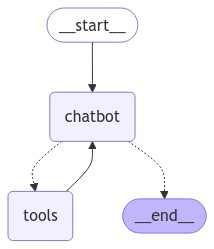

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


### 7. 运行图

现在，我们可以询问机器人超出其训练数据范围的问题。

#### 代码解析

1. **`while True` 循环**：
   - 这是一个无限循环，用于保持对话的持续进行，直到用户输入退出命令为止。每次用户输入一条消息，系统都会将消息传递给机器人进行处理。

2. **用户输入**：
   - `input("User: ")` 用于从用户处获取输入信息，模拟与机器人对话的场景。
   - 如果用户输入的是 `"quit"`、`"exit"` 或 `"q"`，系统将打印 `"Goodbye!"` 并退出循环，结束程序。

3. **`graph.stream`**：
   - `graph.stream({"messages": [("user", user_input)]})` 会将用户的输入消息传递给状态图（graph）进行处理，`graph` 会根据流程生成相应的回复。
   - `"messages": [("user", user_input)]`：这是传递给机器人对话系统的输入消息，表示来自用户的输入内容。

4. **遍历 `event.values()`**：
   - `graph.stream` 会生成一系列的 `event`，每个 `event` 都包含机器人的响应消息。通过遍历 `event.values()`，我们可以获取每个消息的内容。
   - 如果最后一条消息是 `BaseMessage` 类型（机器人回复），则通过 `print("Assistant:", value["messages"][-1].content)` 将机器人的回复输出到控制台。

5. **`BaseMessage`**：
   - `BaseMessage` 是 LangChain 中的消息类型，用于表示机器人和用户之间的消息。在这里，它用于确认从机器人生成的消息是否符合标准格式。

In [19]:
from langchain_core.messages import BaseMessage

# 进入一个无限循环，用于模拟持续的对话
while True:
    # 获取用户输入
    user_input = input("User: ")
    
    # 如果用户输入 "quit"、"exit" 或 "q"，则退出循环，结束对话
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # 打印告别语
        break  # 退出循环

    # 使用 graph.stream 处理用户输入，并生成机器人的回复
    # "messages" 列表中包含用户的输入，传递给对话系统
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        # 遍历 event 的所有值，检查是否是 BaseMessage 类型的消息
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                # 如果消息是 BaseMessage 类型，则打印机器人的回复
                print("Assistant:", value["messages"][-1].content)


Assistant: 
Assistant: [{"url": "https://docs.crewai.com/concepts/flows", "content": "By ensuring that the final method\u2019s output is returned and providing access to the state, CrewAI Flows make it easy to integrate the results of your AI workflows into larger applications or systems, while also maintaining and accessing the state throughout the Flow\u2019s execution. When you run this Flow, the output will change based on the random boolean value generated by the start_method. You can generate a new CrewAI project that includes all the scaffolding needed to create a flow with multiple crews by running the following command: CrewAI offers a powerful visualization tool that allows you to generate interactive plots of your flows, making it easier to understand and optimize your AI workflows. CrewAI provides two convenient methods to generate plots of your flows:"}, {"url": "https://docs.crewai.com/examples/example", "content": "A collection of examples that show how to use CrewAI fra

------------


## 搜索引擎工具赋能前后对比

下面对比使用 搜索引擎工具前后，chatbot 生成结果对比


### 用户问题

```shell
User:  请详细介绍下智能体框架 crewAI最新推出的Flow功能?
```

### ChatBot + Web Search Tool（整合搜索结果后生成正确回答）

```
Assistant: CrewAI最新推出的Flow功能是一种强大的工具，旨在帮助用户更好地集成和管理AI工作流。以下是一些主要特点：

1. **状态管理**：Flow功能可以确保最终方法的输出被返回，并且在Flow执行过程中可以访问和维护状态。这意味着用户可以在整个工作流中跟踪和管理数据状态。

2. **动态输出**：当运行Flow时，输出会根据由`start_method`生成的随机布尔值而变化。这种动态特性使得用户可以创建更加灵活和响应式的AI应用。

3. **可视化工具**：CrewAI提供了强大的可视化工具，可以生成交互式图形，帮助用户更好地理解和优化他们的AI工作流。用户可以通过这些图形直观地看到工作流的运行情况和数据流动。

4. **便捷的项目生成**：CrewAI允许用户通过简单的命令生成一个新项目，其中包括创建具有多个crew的Flow所需的所有框架。这使得用户能够快速上手并开始构建他们的AI工作流。

5. **示例和文档**：CrewAI还提供了一系列示例，展示如何使用该框架来自动化工作流，帮助用户更好地理解和应用Flow功能。

要获取更多详细信息和具体示例，可以访问CrewAI的[官方文档](https://docs.crewai.com/concepts/flows)。
```

### ChatBot-only（模型自己编造的 LangGraph 项目描述）

```
Assistant: 截至我知识的截止日期（2023年10月），关于智能体框架 CrewAI 及其最新推出的 Flow 功能的信息并不在我的数据库中。因此，我无法提供关于该功能的具体细节或介绍。

不过，通常来说，智能体框架（如 CrewAI）可能会推出一些新功能以增强其智能体的能力和用户体验。Flow 功能可能涉及以下几个方面：

1. **工作流自动化**：Flow 功能可能允许用户创建和管理工作流，以自动化任务和流程，提高效率。

2. **用户交互**：可能增强智能体与用户之间的交互，提供更自然和流畅的对话体验。

3. **数据流动**：可能涉及数据在系统之间的流动，使得信息能够更快速和准确地传递。

4. **集成与兼容性**：Flow 功能可能与其他工具和平台集成，提供更广泛的应用场景。

5. **可视化界面**：用户可能能够通过可视化界面更直观地设计和管理工作流。

为了获取最新和最准确的信息，建议访问 CrewAI 的官方网站或查看相关的发布公告和文档。如果有具体问题或想了解某一方面，欢迎随时告诉我！
```

------------

# Homework: 

1. 运行和测试第1部分的聊天机器人（ChatBot-Only），并尝试找到一个其无法回答正确的事实性问题。
1. 使用联网查询工具（如：Tavily），在第2部分的聊天机器人（ChatBot + Tool）上测试相同问题，并对比生成结果。 

------

##

## 第 3 部分：为聊天机器人添加记忆功能

目前机器人可以使用工具来回答问题，但它还无法记住之前的对话内容。为了解决这个问题，我们将为机器人添加记忆功能，让它能够维护对话状态并实现多轮对话。

-----------

`MemorySaver` 是 LangGraph 中的一个检查点机制（checkpointing），用于保存和恢复对话或任务执行的状态。通过 `MemorySaver`，我们可以在每个步骤后保存机器人的状态，并在之后恢复对话，允许机器人具有“记忆”功能，支持多轮对话、错误恢复、时间旅行等功能。

### `MemorySaver` 的核心功能

1. **状态持久化**：
   - `MemorySaver` 以内存的形式保存对话或任务的当前状态。在每次状态图（StateGraph）执行时，`MemorySaver` 会记录执行到某个节点的状态，并将状态保存在内存中。
   - 在实际应用中，可以替换成 `SqliteSaver` 或 `PostgresSaver`，将状态保存到数据库中，以便在系统重新启动后仍能恢复之前的对话。
   - 参考文档：https://langchain-ai.github.io/langgraph/how-tos/persistence/

2. **多轮对话支持**：
   - 使用 `MemorySaver`，每次调用状态图时，都会将对话的上下文保存下来。当用户重新发送消息时，机器人可以加载先前的状态，继续进行对话，而不会丢失上下文。
   - 例如，用户可以在多轮对话中提到之前的内容，机器人能够记住这些信息并做出相应的反应。

3. **错误恢复**：
   - 在任务执行过程中，如果发生了错误，`MemorySaver` 可以帮助机器人恢复到之前的状态，从而重试任务或采取其他措施来处理错误。
   - 它可以让机器人在任务失败或异常时从上一次成功的状态继续执行，而无需从头开始。

4. **时间旅行**：
   - `MemorySaver` 还支持时间旅行功能。开发者可以回溯到之前的某个对话状态，从那个时间点继续执行不同的分支，这在调试和交互式应用中非常有用。
   - 用户或开发者可以选择从某个保存的状态点重新开始，并探索不同的执行路径。

### 使用场景

- **对话系统**：当用户和机器人之间进行多轮对话时，机器人需要记住之前的消息和上下文，以便提供连续性的回复。`MemorySaver` 能帮助机器人保存对话的状态，并在下次调用时恢复先前的对话。
  
- **任务执行系统**：在复杂任务执行流程中，如果发生中断或错误，`MemorySaver` 能帮助系统从最近的检查点恢复，继续完成未完成的任务。

- **调试与实验**：开发者可以通过保存多个状态检查点，回溯到不同的状态节点，进行调试或探索不同的对话分支和执行路径。

### 代码示例

```python
from langgraph.checkpoint.memory import MemorySaver

# 创建内存检查点
memory = MemorySaver()

# 在编译图时，将 MemorySaver 作为检查点传递
graph = graph_builder.compile(checkpointer=memory)

# 执行状态图，保存当前对话的状态
config = {"configurable": {"thread_id": "1"}}
events = graph.stream({"messages": [("user", "Hi, what's the weather today?")]}, config)

# 在下次调用时，从内存检查点恢复对话状态
events = graph.stream({"messages": [("user", "Can you tell me tomorrow's weather too?")]}, config)
```

### 总结

`MemorySaver` 是 LangGraph 中用于在内存中保存对话状态的机制，支持机器人的多轮对话、状态恢复和时间旅行等功能。它通过检查点机制，使机器人可以在任务或对话的不同阶段保存并恢复状态，从而提高对话系统的连续性和容错能力。


### 1. 创建 MemorySaver 检查点



In [21]:
from langgraph.checkpoint.memory import MemorySaver

# 创建内存检查点
memory = MemorySaver()

### 2. 使用检查点编译图



在编译图时，我们将提供检查点功能，机器人可以在每个步骤中保存状态。



In [22]:
graph = graph_builder.compile(checkpointer=memory)

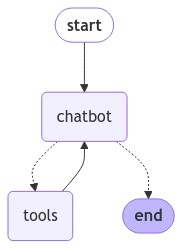

In [23]:
display(Image(graph.get_graph().draw_mermaid_png()))

### 3. 执行聊天机器人

我们仍然按照之前的方式执行机器人，只是这次它会在每一步保存对话状态。


#### 代码解析

1. **config 配置**：
   - `config` 是一个包含对话线程信息的字典，用于指定本次对话的唯一线程 ID。在这个例子中，`thread_id` 被设置为 `"1"`，这意味着该对话会与该线程关联。
   - 每个线程 ID 代表一个独立的对话流，使用 `MemorySaver` 时，机器人可以在同一个 `thread_id` 下记住对话的上下文。

2. **用户输入消息**：
   - `user_input` 表示用户的输入消息，在这里用户输入了 `"Hi there! My name is Peng."`。这个消息将作为对话的起始消息传递给机器人。

3. **graph.stream**：
   - `graph.stream` 是用于执行状态图的函数。它会根据传入的消息和配置执行对话流程。
   - `{"messages": [("user", user_input)]}`：第一个参数包含用户的输入消息。消息格式是一个元组，`("user", user_input)` 表示这是来自用户的消息。
   - `config`：第二个参数指定对话的线程配置，这里使用 `{"configurable": {"thread_id": "1"}}`，表示这次对话属于线程 ID 为 `1` 的对话流。
   - `stream_mode="values"`：设置流模式为 `"values"`，表示返回消息中的内容数据。

4. **遍历事件并打印消息**：
   - `for event in events` 遍历每个从 `graph.stream` 中返回的事件，`event["messages"][-1]` 获取每个事件中的最后一条消息。
   - `pretty_print()`：调用消息对象的 `pretty_print()` 方法来格式化并打印消息的内容。这通常用于输出对话中的 AI 响应或工具调用结果。


In [24]:
config = {"configurable": {"thread_id": "1"}}

# 用户输入的消息
user_input = "Hi there! My name is Peng."

# 第二个参数 config 用于设置对话线程 ID
# 在这里，"thread_id" 是唯一标识符，用于保存和区分对话线程。
# 每个对话线程的状态将由 MemorySaver 保存下来，因此可以跨多轮对话继续进行。
events = graph.stream(
    {"messages": [("user", user_input)]},  # 第一个参数传入用户的输入消息，消息格式为 ("user", "输入内容")
    config,  # 第二个参数用于指定线程配置，包含线程 ID
    stream_mode="values"  # stream_mode 设置为 "values"，表示返回流式数据的值
)

# 遍历每个事件，并打印最后一条消息的内容
for event in events:
    # 通过 pretty_print 打印最后一条消息的内容
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Peng.
================================== Ai Message ==================================

Hello Peng! How can I assist you today?


在下次执行时，机器人将记住之前的对话内容：



In [25]:
user_input = "Remember my name?"

events = graph.stream(
    {"messages": [("user", user_input)]},
    config,
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Peng! How can I help you today?


通过这两步操作，您已经成功为机器人添加了对话记忆功能，它可以记住之前的交互，并在后续的对话中做出相应的回应。



In [26]:
# 机器人仅记住同一个线程中的历史对话，尝试切换到线程2
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember personal data or previous interactions. However, I'm here to help you with any questions or information you need! How can I assist you today?


检查点让机器人可以记住对话状态，您可以通过 `get_state` 函数查看机器人当前的状态：



In [27]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Peng.', id='3fdc96df-3642-4502-b27e-bcd7d68c205f'), AIMessage(content='Hello Peng! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 87, 'total_tokens': 98}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857', 'finish_reason': 'stop', 'logprobs': None}, id='run-a94b40f6-7943-4ffe-9a06-523716ffd4a1-0', usage_metadata={'input_tokens': 87, 'output_tokens': 11, 'total_tokens': 98}), HumanMessage(content='Remember my name?', id='72324598-e56a-4aae-8e70-50a8cf399183'), AIMessage(content='Yes, I remember your name is Peng! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 109, 'total_tokens': 126}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857', 'finish_reason': 'stop', 'logpr

### 使用 Pandas 表格呈现状态

对于其中的 messages 等结构化数据，可以将其转换为 Pandas DataFrame 进行展示。

In [28]:
import pandas as pd

# 将消息内容转换为 DataFrame 显示
messages = snapshot.values['messages']
df = pd.DataFrame([{
    'content': msg.content,
    'message_id': msg.id,
    'type': type(msg).__name__,
    'token_usage': msg.response_metadata.get('token_usage') if hasattr(msg, 'response_metadata') else None
} for msg in messages])

df  # Jupyter 会自动渲染 DataFrame

,content,message_id,type,token_usage
0,Hi there! My name is Peng.,3fdc96df-3642-4502-b27e-bcd7d68c205f,HumanMessage,None
1,Hello Peng! How can I assist you today?,run-a94b40f6-7943-4ffe-9a06-523716ffd4a1-0,AIMessage,"{'completion_tokens': 11, 'prompt_tokens': 87,..."
2,Remember my name?,72324598-e56a-4aae-8e70-50a8cf399183,HumanMessage,None
3,"Yes, I remember your name is Peng! How can I h...",run-fdf94b39-a06e-449d-962b-d572b9f3d6b2-0,AIMessage,"{'completion_tokens': 17, 'prompt_tokens': 109..."


---



## 第 4 部分：引入人类审查



有时机器人可能需要人类的介入来做出复杂决策，或者某些任务需要人类批准。LangGraph 支持这种“人类参与”的工作流，您可以在对话中加入人类审查。

第4部分，主要展示了如何通过 LangGraph 进行多轮对话和工具调用，并且能够手动更新对话状态、插入工具调用的结果，之后继续执行对话。

### 1. 编译图时添加中断



我们可以通过 `interrupt_before` 参数，在工具节点执行之前中断对话，让人类有机会审查。


**编译状态图**：
   - `graph_builder.compile()` 用于编译状态图，生成可执行的 `CompiledGraph` 对象。
   - `checkpointer=memory` 使用内存作为检查点保存对话状态。
   - `interrupt_before=["tools"]` 表示在执行 "tools" 节点之前中断，允许手动干预。

In [29]:
# 编译状态图，指定在工具节点之前进行中断
graph = graph_builder.compile(
    checkpointer=memory,  # 使用 MemorySaver 作为检查点系统
    interrupt_before=["tools"],  # 在进入 "tools" 节点前进行中断
)

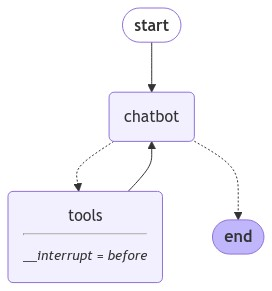

In [30]:
display(Image(graph.get_graph().draw_mermaid_png()))

### 2. 执行对话并在工具调用前中断



我们现在来执行对话，并在工具节点之前进行中断，以便人类介入。



In [31]:
# 用户输入的消息
user_input = "我正在学习LangGraph。你能帮我做一些研究吗？"
# 配置新的对话线程 ID，用于保存和恢复对话状态
config = {"configurable": {"thread_id": "3"}}

# 使用 stream 方法处理用户输入并返回事件
events = graph.stream(
    {"messages": [("user", user_input)]},
    config,
    stream_mode="values"
)

# 遍历每个事件并输出最后一条消息的内容
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()  # 打印消息内容

================================ Human Message =================================

我正在学习LangGraph。你能帮我做一些研究吗？
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_7aNeaPmidh0QCdwFlI5eSUZy)
 Call ID: call_7aNeaPmidh0QCdwFlI5eSUZy
  Args:
    query: LangGraph 研究


检查图的状态，确认已经中断。

**获取状态快照**：
   - 使用 `graph.get_state(config)` 获取当前对话的状态快照。
   - `snapshot.next` 显示下一个将要执行的节点（在中断时为 "tools" 节点）。

In [32]:
# 获取当前对话的状态快照
snapshot = graph.get_state(config)
# 查看快照中下一个要执行的节点
snapshot.next

('tools',)

请注意，与上次不同，“下一个”节点被设置为'tools'。我们在这里中断了！让我们检查一下工具调用。

In [33]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph 研究'},
  'id': 'call_7aNeaPmidh0QCdwFlI5eSUZy',
  'type': 'tool_call'}]

这个查询看起来很合理。这里没有需要过滤的内容。人类能做的最简单的事情就是让图形继续执行。我们在下面这样做。

**接下来，继续执行图！**

传入 `None` 便是让图从它停止的地方继续，而不会向状态中添加任何新内容。

In [34]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_7aNeaPmidh0QCdwFlI5eSUZy)
 Call ID: call_7aNeaPmidh0QCdwFlI5eSUZy
  Args:
    query: LangGraph 研究
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://zenn.dev/zenkigen_tech/articles/536801e61d0689", "content": "LangGraph\u306eexamples\u304b\u3089\u30a8\u30fc\u30b8\u30a7\u30f3\u30c8\u306e\u4f5c\u308a\u65b9\u3092\u5b66\u3076 ... \u304b\u3089\u3001\u30a2\u30a4\u30c7\u30a2\u5275\u51fa\u3001\u5b9f\u9a13\u306e\u5b9f\u884c\u3068\u7d50\u679c\u306e\u8981\u7d04\u3001\u8ad6\u6587\u306e\u57f7\u7b46\u3001\u30d4\u30a2\u30ec\u30d3\u30e5\u30fc\u3068\u3044\u3063\u305f\u79d1\u5b66\u7814\u7a76\u306e\u30b5\u30a4\u30af\u30eb\u3092\u81ea\u52d5\u7684\u306b\u9042\u884c\u3059\u308bAI\u30b7\u30b9\u30c6\u30e0\u300cThe AI Scientist\u300d\u304c\u767a\u8868\u3055\u308c\u8a71\u984c\u306b\u306a\u308a\u307e\u3057

### 3. 人工介入，修改工具执行结果

我们直接使用人工定义的内容，作为工具的返回结果。

**手动插入工具调用结果**：
   - 创建一个 `ToolMessage` 消息对象，内容是手动提供的工具调用结果，如 `"LangGraph 是一个用于构建状态化、多参与者应用的库"`。
   - `tool_call_id` 使用之前的工具调用 ID 来关联这个工具调用消息。

**更新状态**：
   - 通过 `graph.update_state(config, {"messages": [tool_message]})` 手动更新对话状态，插入新的工具调用结果。

**继续执行对话**：
   - 使用 `graph.stream(None, config)` 继续执行对话，处理工具调用后的节点。
   - 打印后续生成的消息，显示机器人对工具调用结果的响应。

**工具调用最终输出是人工手动输入的内容**

In [35]:
# 手动生成一个工具调用的消息，并更新到对话状态中
tool_message = ToolMessage(
    content="LangGraph 是一个用于构建状态化、多参与者应用的库。",  # 工具调用返回的内容
    tool_call_id=snapshot.values["messages"][-1].tool_calls[0]["id"]  # 关联工具调用的 ID
)

# 更新对话状态，加入工具调用的结果
graph.update_state(config, {"messages": [tool_message]})

# 继续执行对话，查看工具调用后的后续处理
events = graph.stream(None, config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()  # 打印后续生成的消息内容

================================= Tool Message =================================

LangGraph 是一个用于构建状态化、多参与者应用的库。


---------

## 第5部分： 查看 ChatBot 历史对话

在 LangGraph 中，可以使用 `graph.get_state_history()` 来获取对话的所有历史状态。

传入参数：`{"configurable": {"thread_id": "1"}}`，可以获取指定线程的对话状态。

```python
# 获取指定线程 ID 的所有历史状态
history = graph.get_state_history({"configurable": {"thread_id": "1"}})

# 遍历历史记录，打印每个状态中的所有消息
for state in history:
    print("=== 对话历史 ===")
    # 遍历每个状态中的消息记录
    for message in state.values["messages"]:
        if isinstance(message, BaseMessage):
            # 根据消息类型区分用户与机器人
            if "user" in message.content.lower():
                print(f"User: {message.content}")
            else:
                print(f"Assistant: {message.content}")
```


### **为什么不用 events 获取历史？**

如果您使用 events，每次调用 graph.stream() 时，您只能获取当前的对话步骤，而不是之前的对话记录。要保留对话历史，您需要在每次获取 events 时将结果手动保存，这样会增加复杂度。


### 对话历史去重

直接运行上面的代码，可能会出现重复的对话历史。

- **问题来源**：重复的状态快照和无消息的中间状态导致了多次重复的对话历史和空对话历史。

为了处理这些问题，我们可以引入更严格的过滤条件，并确保只打印那些包含**新消息**或有效消息的状态。

- **解决方案**：通过检查消息类型和 ID 来过滤无效和重复的消息，并只输出真正包含对话内容的状态快照。

### 代码解析

1. **`valid_messages` 列表**：这段代码检查每条消息是否是 `BaseMessage` 类型，同时确保该消息之前没有被处理过。如果消息符合这些条件，则被视为有效消息。

2. **输出条件**：只有当存在有效消息时，才打印 `=== 对话历史 ===`，否则打印 `=== 空对话历史（无有效消息） ===`。

3. **避免重复输出**：通过 `seen_message_ids` 集合来存储已经处理过的消息 ID，确保每条消息只被打印一次，防止重复输出。

In [36]:
# 获取指定线程 ID 的所有历史状态
history = graph.get_state_history({"configurable": {"thread_id": "3"}})

# 使用集合存储已处理过的消息 ID
seen_message_ids = set()

# 遍历历史记录，打印每个状态中的所有消息
for state in history:
    # 获取状态中的消息列表
    messages = state.values.get("messages", [])
    
    # 检查是否存在至少一条未处理的 BaseMessage 类型的消息
    valid_messages = [msg for msg in messages if isinstance(msg, BaseMessage) and msg.id not in seen_message_ids]
    
    if valid_messages:
        print("=== 对话历史 ===")
        for message in valid_messages:
            seen_message_ids.add(message.id)  # 记录消息 ID，避免重复处理
            if "user" in message.content.lower():
                print(f"User: {message.content}")
            else:
                print(f"Assistant: {message.content}")
    else:
        print("=== 空对话历史（无有效消息） ===")

=== 对话历史 ===
Assistant: 我正在学习LangGraph。你能帮我做一些研究吗？
Assistant: 
Assistant: [{"url": "https://zenn.dev/zenkigen_tech/articles/536801e61d0689", "content": "LangGraph\u306eexamples\u304b\u3089\u30a8\u30fc\u30b8\u30a7\u30f3\u30c8\u306e\u4f5c\u308a\u65b9\u3092\u5b66\u3076 ... \u304b\u3089\u3001\u30a2\u30a4\u30c7\u30a2\u5275\u51fa\u3001\u5b9f\u9a13\u306e\u5b9f\u884c\u3068\u7d50\u679c\u306e\u8981\u7d04\u3001\u8ad6\u6587\u306e\u57f7\u7b46\u3001\u30d4\u30a2\u30ec\u30d3\u30e5\u30fc\u3068\u3044\u3063\u305f\u79d1\u5b66\u7814\u7a76\u306e\u30b5\u30a4\u30af\u30eb\u3092\u81ea\u52d5\u7684\u306b\u9042\u884c\u3059\u308bAI\u30b7\u30b9\u30c6\u30e0\u300cThe AI Scientist\u300d\u304c\u767a\u8868\u3055\u308c\u8a71\u984c\u306b\u306a\u308a\u307e\u3057\u305f\u3002 ..."}, {"url": "https://python.langchain.ac.cn/docs/langgraph/", "content": "\ud83e\udd9c\ud83d\udd78\ufe0fLangGraph. \u26a1 Building language agents as graphs \u26a1. Overview . LangGraph is a library for building stateful, multi-actor applications with

# Homework: 

1. 运行和测试第1部分的聊天机器人（ChatBot-Only），并尝试找到一个其无法回答正确的事实性问题。
1. 使用联网查询工具（如：Tavily），在第2部分的聊天机器人（ChatBot + Tool）上测试相同问题，并对比生成结果。 